# Are we consuming more local?

## Research questions

1. Where are the products we consume in our everyday life coming from?

    - Which countries produce the primary resources (ground ingredients) consumed in Switzerland?
    - Which countries manufacture most of the products consumed in Switzerland?


2. Is there a trend over time to consume more local products?

    - Are new products mostly using primary resources from Switzerland? Or from other countries inside Europe?
    - Are new products mostly manufactured in Switzerland? Or from other countries inside Europe?
    - Is there a trend over time to local products to promote their origin?

## Dataset

Open Food Facts (https://world.openfoodfacts.org/data)

Additional datasets “Evolution de la consommation de denrées alimentaires en Suisse” (https://opendata.swiss/fr/dataset/entwicklung-des-nahrungsmittelverbrauches-in-der-schweiz-je-kopf-und-jahr1) and “Dépenses fédérales pour l’agriculture et l’alimentation” (https://opendata.swiss/fr/dataset/bundesausgaben-fur-die-landwirtschaft-und-die-ernahrung1) from https://opendata.swiss/fr/group/agriculture

A last additional dataset for the second question of the project
https://www.gate.ezv.admin.ch/swissimpex/public/bereiche/waren/result.xhtml
Total of imports of agriculture, forestry and fishing goods


In [164]:
import re
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import timedelta
import findspark
findspark.init()
import pyspark

from functools import reduce
from pyspark.sql import *
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql.functions import to_date, last_day,date_add
from datetime import timedelta

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [165]:
DATA_FOLDER = 'data'
openfood_file = "/en.openfoodfacts.org.products.csv"
temp_file = 'output/temp.csv'
countries_mapping_file = '/mapping_countries_revised.csv'
cleaned_off_dataset = 'output/cleaned_off.csv'

#Cleaning the countries
cities_file = "data/countries_cleaning/cities.csv"
countries_file = "data/countries_cleaning/countries.csv"
output_mapping_just_countries = "data/countries_cleaning/output/mapping_just_countries.csv"

In [166]:
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

# Cleaning countries

In [168]:
dataset_main = spark.read.csv(DATA_FOLDER + openfood_file, header=True, mode="DROPMALFORMED", sep = '\t')

dataset_main.createOrReplaceTempView("data_main")

# Filter required columns
p_id_col = " code, "
geo_tags_cols = " manufacturing_places_tags, countries_tags "

off_df = spark.sql("SELECT" + p_id_col + geo_tags_cols + " FROM data_main")
off_df.printSchema()

root
 |-- code: string (nullable = true)
 |-- manufacturing_places_tags: string (nullable = true)
 |-- countries_tags: string (nullable = true)



In [169]:
off_all_size = off_df.count()
off_cols_size = len(off_df.columns)
print("All data Size:\n" + str(off_cols_size) + "(columns) * " + str(off_all_size) + "(rows)")

All data Size:
3(columns) * 709945(rows)


In [170]:
# Find number of missing data
off_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in off_df.columns]).show()

+----+-------------------------+--------------+
|code|manufacturing_places_tags|countries_tags|
+----+-------------------------+--------------+
|   0|                   641206|           554|
+----+-------------------------+--------------+



In [171]:
off_df.createOrReplaceTempView("off_df")

sql_filter = "SELECT * FROM off_df WHERE \
            countries_tags is not NULL AND manufacturing_places_tags is not NULL "

off_p_df = spark.sql(sql_filter)
off_p_all_size = off_p_df.count()
off_p_cols_size = len(off_p_df.columns)
print("Full GEO information data Size:\n" + str(off_p_cols_size) + "(columns) * " + str(off_p_all_size) + "(rows)")

Full GEO information data Size:
3(columns) * 68672(rows)


In [172]:
off_p_df.show(5)

+-------------+-------------------------+-----------------+
|         code|manufacturing_places_tags|   countries_tags|
+-------------+-------------------------+-----------------+
|0000000020114|                   france|        en:france|
|0000000274722|                   france|        en:france|
|0000000290616|          brossard-quebec|        en:canada|
|0000000394710|          brossard-quebec|        en:canada|
|0000001071894|           united-kingdom|en:united-kingdom|
+-------------+-------------------------+-----------------+
only showing top 5 rows



In [173]:
# Remove "en:" occurances before name of each country in coutries_tags
off_p_df = off_p_df.withColumn('countries_tags', F.regexp_replace('countries_tags', "en:", ""))
off_p_df.show(5)

+-------------+-------------------------+--------------+
|         code|manufacturing_places_tags|countries_tags|
+-------------+-------------------------+--------------+
|0000000020114|                   france|        france|
|0000000274722|                   france|        france|
|0000000290616|          brossard-quebec|        canada|
|0000000394710|          brossard-quebec|        canada|
|0000001071894|           united-kingdom|united-kingdom|
+-------------+-------------------------+--------------+
only showing top 5 rows



In [174]:
countries_mapping = off_p_df.toPandas()
countries_mapping.head()

,code,manufacturing_places_tags,countries_tags
0,0000000020114,france,france
1,0000000274722,france,france
2,0000000290616,brossard-quebec,canada
3,0000000394710,brossard-quebec,canada
4,0000001071894,united-kingdom,united-kingdom


In [175]:
# create a new database mapping each country to some labels

countries_mapping['all_countries'] = countries_mapping.manufacturing_places_tags +"," + countries_mapping.countries_tags

In [176]:
countries_mapping.head()

,code,manufacturing_places_tags,countries_tags,all_countries
0,0000000020114,france,france,"france,france"
1,0000000274722,france,france,"france,france"
2,0000000290616,brossard-quebec,canada,"brossard-quebec,canada"
3,0000000394710,brossard-quebec,canada,"brossard-quebec,canada"
4,0000001071894,united-kingdom,united-kingdom,"united-kingdom,united-kingdom"


In [177]:
countries = pd.concat([pd.Series(row['all_countries'].split(','))              
                    for _, row in countries_mapping.iterrows()]).reset_index(drop=True)
countries.head()

0             france
1             france
2             france
3             france
4    brossard-quebec
dtype: object

In [178]:
len(countries)

192203

In [179]:
countries = countries.drop_duplicates().reset_index(drop=True)
countries = countries.str.replace("-", " ") 

# Remove numbers from name of countries
countries = countries.str.replace('\d+', '')

print(len(countries))

12357


In [180]:
countries.head()

0             france
1    brossard quebec
2             canada
3     united kingdom
4           brossard
dtype: object

We have extracted all unique values in country_tags and manufacturing_places_tags columns. We have 12357 unique entry. Now we should map each of these entries to a country code.

In [181]:
# map_countries will keep the mappings
map_countries = pd.DataFrame(columns=['input', 'country_code'])
remained_countries = countries.copy()

In [182]:
def print_cleaning_status():
    print("{0} name of countries have been detected in uncleaned dataset".format(len(map_countries)))
    print("{0} name of countries have remained".format(len(remained_countries)))    

In [183]:
print_cleaning_status()

0 name of countries have been detected in uncleaned dataset
12357 name of countries have remained


Two external databases were used for mapping of country names and city names. https://www.geodatasource.com

### Using country name

In [184]:
dataset_countries = pd.read_csv(countries_file, error_bad_lines=False)
dataset_countries.head()

,CC_FIPS,COUNTRY_NAME
0,AA,Aruba
1,AC,Antigua and Barbuda
2,AE,United Arab Emirates
3,AF,Afghanistan
4,AG,Algeria


In [185]:
def map_country(data, country_code):
    global map_countries
    map_countries = map_countries.append({'input': data, 'country_code': country_code}, ignore_index=True)

def find_country(data):
    # map data with country code
    output = dataset_countries[dataset_countries.CC_FIPS.str.match(data, case=False)]
    
    if len(data) <=2:
        # If length of data is less than 3 and has not been matched with a country code, data is not valid
        return 0
    
    if not len(output):
        # map data with name of a country 
        output = dataset_countries[dataset_countries.COUNTRY_NAME.str.match(data, case=False)]
        
    if not len(output):
        # map data with name of a country 
        output = dataset_countries[dataset_countries.COUNTRY_NAME.str.contains(data, case=False)]
        
    if len(output):
        return output.iloc[0].CC_FIPS
    return 0

def assign_country_code(row):
    output = find_country(row)
    if output:
        map_country(row, output)
        return True
    return False

In [186]:
for i in range(len(remained_countries)):
    if assign_country_code(remained_countries[i]):
        remained_countries = remained_countries.drop([i])
        i -=1

In [187]:
print_cleaning_status()

204 name of countries have been detected in uncleaned dataset
12153 name of countries have remained


#### Find entries which contain name of a country

In [188]:
for index, row in dataset_countries.iterrows():
    # If data contains name of a country before other words
    output = remained_countries[remained_countries.str.contains(row.COUNTRY_NAME + " ", case=False, na=False)]
    
    if not len(output):
        # If data contains name of a country after other words
         output = remained_countries[remained_countries.str.contains(" " + row.COUNTRY_NAME, case=False, na=False)]   
    
    for i in range(len(output)):
        map_country(output.iloc[i], row.CC_FIPS)
        remained_countries = remained_countries.drop(remained_countries[remained_countries == output.iloc[i]].index[0])

In [189]:
print_cleaning_status()

446 name of countries have been detected in uncleaned dataset
11911 name of countries have remained


In [190]:
map_countries.tail(10)

,input,country_code
436,distribue par erabliere turkey hill ltee,TU
437,taichung taiwan,TW
438,taidong taiwan,TW
439,nantao taiwan,TW
440,penhu taiwan,TW
441,shinchu taiwan,TW
442,manchester united kingdom,UK
443,en united kingdom,UK
444,united states if america,US
445,zambia lusaka,ZA


In [191]:
# Save 776 detected inputs 
map_countries.to_csv(output_mapping_just_countries, index=False)

#### Using City names

In [192]:
# Find name of cities and replace with country code (Here some bias may happen, some cities have similar name)

dataset_cities = pd.read_csv(cities_file, sep=',', error_bad_lines=False, encoding = "utf-8")

b'Skipping line 3404: expected 2 fields, saw 3\nSkipping line 26344: expected 2 fields, saw 3\nSkipping line 26424: expected 2 fields, saw 3\nSkipping line 27358: expected 2 fields, saw 3\nSkipping line 28220: expected 2 fields, saw 3\nSkipping line 28221: expected 2 fields, saw 3\nSkipping line 28382: expected 2 fields, saw 3\nSkipping line 28734: expected 2 fields, saw 3\nSkipping line 29051: expected 2 fields, saw 3\nSkipping line 29056: expected 2 fields, saw 3\nSkipping line 29128: expected 2 fields, saw 3\nSkipping line 29183: expected 2 fields, saw 3\nSkipping line 44241: expected 2 fields, saw 3\nSkipping line 65686: expected 2 fields, saw 3\nSkipping line 67481: expected 2 fields, saw 3\nSkipping line 69168: expected 2 fields, saw 3\nSkipping line 70683: expected 2 fields, saw 3\nSkipping line 74874: expected 2 fields, saw 3\nSkipping line 76715: expected 2 fields, saw 3\nSkipping line 79939: expected 2 fields, saw 3\nSkipping line 79940: expected 2 fields, saw 3\nSkipping lin

b'Skipping line 2388360: expected 2 fields, saw 3\nSkipping line 2415305: expected 2 fields, saw 3\nSkipping line 2435121: expected 2 fields, saw 3\nSkipping line 2468541: expected 2 fields, saw 3\nSkipping line 2487174: expected 2 fields, saw 3\nSkipping line 2498367: expected 2 fields, saw 3\nSkipping line 2503894: expected 2 fields, saw 3\nSkipping line 2504687: expected 2 fields, saw 3\nSkipping line 2506781: expected 2 fields, saw 3\nSkipping line 2510013: expected 2 fields, saw 3\nSkipping line 2514107: expected 2 fields, saw 3\nSkipping line 2515979: expected 2 fields, saw 3\nSkipping line 2545297: expected 2 fields, saw 3\n'
b'Skipping line 2634015: expected 2 fields, saw 3\nSkipping line 2660539: expected 2 fields, saw 3\nSkipping line 2679358: expected 2 fields, saw 3\nSkipping line 2684685: expected 2 fields, saw 3\nSkipping line 2697005: expected 2 fields, saw 4\nSkipping line 2697793: expected 2 fields, saw 3\nSkipping line 2697986: expected 2 fields, saw 3\nSkipping line 

In [193]:
dataset_cities.head()

,CC_FIPS,FULL_NAME_ND
0,AN,Aixas
1,AN,Aixirivall
2,AN,Aixovall
3,AN,Andorra la Vella
4,AN,Ansalonga


In [194]:
print("Number of cities in the external dataset: {0}".format(len(dataset_cities)))

Number of cities in the external dataset: 2915558


In [195]:
def find_city(data):
    
    if len(data) <=2:
        # If length of data is less than 3 data is not valid
        return 0
    
    # map data with name of a city 
    output = dataset_cities[dataset_cities.FULL_NAME_ND.str.match(data, case=False, na=False)]
        
    if not len(output):
        # map data if it contains name of a city 
        output = dataset_cities[dataset_cities.FULL_NAME_ND.str.contains(" " + data + "|"+ data + " ", case=False, regex=True, na=False)]

    if len(output):
            print(data + "-->" +output.iloc[0].CC_FIPS)
            return output.iloc[0].CC_FIPS
    return 0

def assign_country_code_using_city(row):
    output = find_city(row)
    if output:
        map_country(row, output)
        return True
    return False

In [196]:
seen = 0
interval = 2000

In [ ]:
remained_countries = remained_countries.reset_index(drop=True)

if len(remained_countries) < interval:
    interval = len(remained_countries)
for i in range(seen, seen + interval):
    if i%50 == 0:
        print(i)
    
    if assign_country_code_using_city(remained_countries[i]):
        remained_countries = remained_countries.drop([i])
        i -=1
        seen = i  

#### Cleanig countries - Conclusion 

In the process of cleaning countries, 12357 unique input were detected in the begining. 
Out of these 12357 entries, 776 of them were mapped to a country with the help of the name of country itself. 
With these 776 mapping, the countries column in our original dataset became completely cleaned.

Just we had to continue the process of cleaning for manufacturing_places column. 

In order to clean the 11581 remained entries we tried to use an external dataset containing name of cities in the world. This approach was successful and we could map most of our data with a country. 
But when we evaluated the mappings, 
we found that there were considerable number of inputs which were mapped to a country by the help of city names but actually they were name of other country but in a language other than English. 
Since this problem could bias our results we gave up this approach.

Finally, we extracted data associated with Europe and Switzerland using countries column. Then we found the most important manufacturers and tried to associate them manually with a valid country for about ~80 most frequent entries. This approach helped us very well and we had enough data to work with in our project (We had more than 74K data just for trade inside the Europe which was convenient for our project).

# Loading data

In [63]:
dataset_main = spark.read.csv(DATA_FOLDER + openfood_file, header=True, mode="DROPMALFORMED", sep = '\t')

dataset_main.createOrReplaceTempView("data_main")

# Filter required columns
p_id_col = " code, "
geo_tags_cols = " manufacturing_places_tags, countries_tags "

off_df = spark.sql("SELECT" + p_id_col + geo_tags_cols + " FROM data_main")
off_df.printSchema()

root
 |-- code: string (nullable = true)
 |-- manufacturing_places_tags: string (nullable = true)
 |-- countries_tags: string (nullable = true)



## Data Cleaning and Preprocessing

In [64]:
off_df.createOrReplaceTempView("off_df")

sql_filter = "SELECT * FROM off_df WHERE countries_tags is not NULL AND manufacturing_places_tags is not NULL"
off_p_df = spark.sql(sql_filter)

off_p_all_size = off_p_df.count()
off_p_cols_size = len(off_p_df.columns)
print("Full GEO information data Size:\n" + str(off_p_cols_size) + "(columns) * " + str(off_p_all_size) + "(rows)")

Full GEO information data Size:
3(columns) * 68672(rows)


In [65]:
# Explode countries
off_p_df = off_p_df\
.withColumn('manufacturing_places_tags', F.explode_outer(F.split('manufacturing_places_tags', ',')))\
.withColumn('countries_tags', F.explode_outer(F.split('countries_tags', ',')))

# Remove "en:" occurances before name of each country in coutries_tags
off_p_df = off_p_df.withColumn('countries_tags', F.regexp_replace('countries_tags', "en:", ""))

# Remove - in name of countries
off_p_df = off_p_df.withColumn('countries_tags', F.regexp_replace('countries_tags', "-", " "))
off_p_df = off_p_df.withColumn('manufacturing_places_tags', F.regexp_replace('manufacturing_places_tags', "-", " "))

# Remove numbers from name of countries
off_p_df = off_p_df.withColumn('countries_tags', F.regexp_replace('countries_tags', "\d+", ""))
off_p_df = off_p_df.withColumn('manufacturing_places_tags', F.regexp_replace('manufacturing_places_tags', "\d+", ""))

In [66]:
off_p_df.show(5)

+-------------+-------------------------+--------------+
|         code|manufacturing_places_tags|countries_tags|
+-------------+-------------------------+--------------+
|0000000020114|                   france|        france|
|0000000274722|                   france|        france|
|0000000290616|          brossard quebec|        canada|
|0000000394710|          brossard quebec|        canada|
|0000001071894|           united kingdom|united kingdom|
+-------------+-------------------------+--------------+
only showing top 5 rows



In [67]:
off_p_df = off_p_df.withColumn("countries", off_p_df["countries_tags"])
off_p_df = off_p_df.withColumn("manufacturing_places", off_p_df["manufacturing_places_tags"])
off_p_df.printSchema()

root
 |-- code: string (nullable = true)
 |-- manufacturing_places_tags: string (nullable = true)
 |-- countries_tags: string (nullable = true)
 |-- countries: string (nullable = true)
 |-- manufacturing_places: string (nullable = true)



In [68]:
off_p_all_size = off_p_df.count()
off_p_cols_size = len(off_p_df.columns)
print("Full GEO information data Size:\n" + str(off_p_cols_size) + "(columns) * " + str(off_p_all_size) + "(rows)")

Full GEO information data Size:
5(columns) * 128781(rows)


In [69]:
# Clean countries
cleaned_countries= pd.read_csv(DATA_FOLDER + countries_mapping_file, sep=',', error_bad_lines=False, encoding = "utf-8").dropna()
cleaned_countries.tail()

,input,country_code
840,england,UK
841,scotland,UK
842,europe,EU
843,mexique,MX
844,hongrie,HU


In [70]:
seen = 0

In [72]:
# This cell should be run twice to avoid memory error

interval = 501
if seen:
    off_p_df = spark.read.csv(temp_file, header=True)

# Clean countries using mapping_countries
for index, row in cleaned_countries.head(seen + interval).iterrows():
        if index < seen:
            continue
        if index%100 == 0:
            print(index)    
        off_p_df = off_p_df.withColumn('manufacturing_places', F.regexp_replace('manufacturing_places', "^" + str(row['input']) + "$", row['country_code']))
        off_p_df = off_p_df.withColumn('countries', F.regexp_replace('countries', "^" + str(row['input']) + "$", row['country_code']))
        seen = index

# Save Spark dataframe in csv file
off_p_df.toPandas().to_csv(temp_file, index=False)

print("Seen: {0}".format(seen))

500
600
700
800
Seen: 844


In [73]:
off_p_df.show(10)

+-------------+-------------------------+--------------+---------+--------------------+
|         code|manufacturing_places_tags|countries_tags|countries|manufacturing_places|
+-------------+-------------------------+--------------+---------+--------------------+
|0000000020114|                   france|        france|       FR|                  FR|
|0000000274722|                   france|        france|       FR|                  FR|
|0000000290616|          brossard quebec|        canada|       CA|     brossard quebec|
|0000000394710|          brossard quebec|        canada|       CA|     brossard quebec|
|0000001071894|           united kingdom|united kingdom|       UK|                  UK|
|0000001938067|          brossard quebec|        canada|       CA|     brossard quebec|
|0000004302544|                 brossard|        canada|       CA|            brossard|
|0000004302544|                   quebec|        canada|       CA|              quebec|
|0000007020254|               et

In [74]:
print("Full GEO information data Size:\n{0}(columns) *{1}(rows)".format(off_p_df.count(),len(off_p_df.columns) ))

Full GEO information data Size:
128781(columns) *5(rows)


In [75]:
#filter europe countries - using FIPS country code
filter_EU ='AL|AN|AM|AU|AJ|BO|BE|BK|BU|HR|CY|EZ|DA|EN|FI|FR|GG|GM|GR|HU|IC|EI|IT|KZ|KV|LG|LS|LH|LU|MK|MT|MD|MN|YI|NL|NO|Pl|PO|RO|RS|SM|LO|SI|SP|SW|SZ|TU|UP|UK|VT'

In [76]:
# store products that are sold in european union (france as ct)
eu_sold_data = off_p_df.filter(off_p_df["countries"].rlike(filter_EU))
print("eu_sold data Size:\n{0}".format(eu_sold_data.count()))

eu_sold data Size:
118996


In [77]:
# store products that are sold in Switzerland- using FIPS country code
swiss_sold_data = off_p_df[off_p_df["countries"] == "SZ"]
print("swiss_sold data Size:\n{0}".format(swiss_sold_data.count()))

swiss_sold data Size:
3885


Now that the two datasets of products sold in the European Union, and products sold in Switzerland are created, the analysis for each one is done. The study is going to focus in the behavior of the "manufacturing place" of those products.

## Find the most important importers in Europe

In [78]:
# Find the most important importers in Europe
eu_sold_data.createOrReplaceTempView("eu_sold_data")
target_manufacture = spark.sql("SELECT manufacturing_places, COUNT(manufacturing_places) FROM eu_sold_data GROUP BY manufacturing_places ORDER BY COUNT(manufacturing_places) DESC")
target_manufacture = target_manufacture.withColumnRenamed('count(manufacturing_places)' , 'Count')
print("Number of Importers:\n" + str(target_manufacture.count()))
target_manufacture.show(5)

Number of Importers:
10015
+--------------------+-----+
|manufacturing_places|Count|
+--------------------+-----+
|                  FR|45824|
|                  SP| 7604|
|                  GM| 4862|
|                  IT| 4505|
|                  UK| 2427|
+--------------------+-----+
only showing top 5 rows



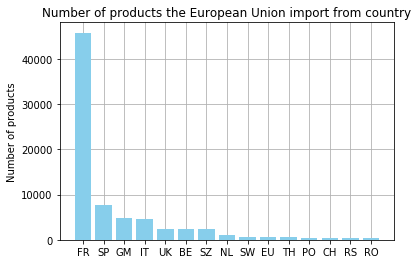

In [79]:
# Extract the 15 most important countries and number of occurances in ingredients.
manufacture_countries = target_manufacture.toPandas() 
manufacture_countries = manufacture_countries.head(15)

# Plot the number of products imported by 15 most important countries
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.bar(manufacture_countries.manufacturing_places, manufacture_countries.Count, zorder=3, color='skyblue')
plt.ylabel('Number of products')   
plt.xticks(manufacture_countries.manufacturing_places)
plt.title('Number of products the European Union import from country')
plt.show()

In [80]:
#Save all manufacturers in Europe
manufacture_countries.to_csv("output/europe_manufacturers.csv", index=False)

## Find the most important importers in Switzerland

In [81]:
# Find dominant importers of ingredients
swiss_sold_data.createOrReplaceTempView("swiss_sold_data")
target_swiss_manufacture = spark.sql("SELECT manufacturing_places, COUNT(manufacturing_places) FROM swiss_sold_data GROUP BY manufacturing_places ORDER BY COUNT(manufacturing_places) DESC")
target_swiss_manufacture = target_swiss_manufacture.withColumnRenamed('count(manufacturing_places)' , 'Count')
print("Number of Importers:\n" + str(target_swiss_manufacture.count()))
target_swiss_manufacture.show(5)

Number of Importers:
695
+--------------------+-----+
|manufacturing_places|Count|
+--------------------+-----+
|                  SZ| 1293|
|                  FR|  654|
|                  GM|  242|
|                  IT|  209|
|                  UK|   75|
+--------------------+-----+
only showing top 5 rows



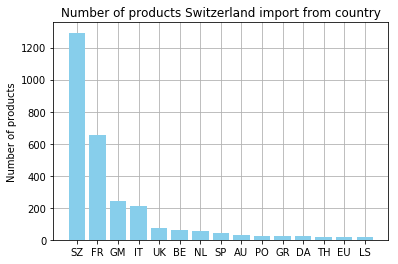

In [82]:
# Extract the 10 most important countries and number of occurances in ingredients.
manufacture_swiss_countries = target_swiss_manufacture.toPandas() 
manufacture_swiss_countries = manufacture_swiss_countries.head(15)

# Plot the number of products imported by 10 most important countries
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.bar(manufacture_swiss_countries.manufacturing_places, manufacture_swiss_countries.Count, zorder=3, color='skyblue')
plt.ylabel('Number of products')   
plt.xticks(manufacture_swiss_countries.manufacturing_places)
plt.title('Number of products Switzerland import from country')
plt.show()

In [83]:
#Save all manufacturers in Switzerland
manufacture_swiss_countries.to_csv("output/switzerland_manufacturers.csv", index=False)

## Trade inside Europe

In [84]:
eu_data = eu_sold_data.filter(eu_sold_data["manufacturing_places"].rlike(filter_EU))
print("Number of data about trade inside the Europe:\n{0}".format(eu_data.count()))

Number of data about trade inside the Europe:
73940


In [85]:
eu_data.show(20)

+-------------+-------------------------+--------------+---------+--------------------+
|         code|manufacturing_places_tags|countries_tags|countries|manufacturing_places|
+-------------+-------------------------+--------------+---------+--------------------+
|0000000020114|                   france|        france|       FR|                  FR|
|0000000274722|                   france|        france|       FR|                  FR|
|0000001071894|           united kingdom|united kingdom|       UK|                  UK|
|0000007730009|                   france|        france|       FR|                  FR|
|0000010090206|                   france|        france|       FR|                  FR|
|0000020004552|                   france|        france|       FR|                  FR|
|0000020424640|                  belgien|       germany|       GM|                  BE|
|0000027533024|           united kingdom|united kingdom|       UK|                  UK|
|0000027533048|           united

## Products' categories

We would like to find which countries import what products. 
We will extract the 5 most important importers of each category.

In [86]:
extra_info_df = ' categories '
categories_df = spark.sql("SELECT" + p_id_col + extra_info_df + " FROM data_main")

In [87]:
# Find number of missing data
categories_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in categories_df.columns]).show()

+----+----------+
|code|categories|
+----+----------+
|   0|    519878|
+----+----------+



In [88]:
# Join table of categories with table of target products (Europe trade)
eu_categories = eu_data.join(categories_df, eu_data.code == categories_df.code).drop(categories_df.code)
eu_categories.show(5)

+-------------+-------------------------+--------------+---------+--------------------+--------------------+
|         code|manufacturing_places_tags|countries_tags|countries|manufacturing_places|          categories|
+-------------+-------------------------+--------------+---------+--------------------+--------------------+
|0000000020114|                   france|        france|       FR|                  FR|Compléments alime...|
|0000000274722|                   france|        france|       FR|                  FR|Plats préparés, P...|
|0000001071894|           united kingdom|united kingdom|       UK|                  UK|Plant-based foods...|
|0000007730009|                   france|        france|       FR|                  FR|Snacks sucrés, Bi...|
|0000010090206|                   france|        france|       FR|                  FR|Aliments et boiss...|
+-------------+-------------------------+--------------+---------+--------------------+--------------------+
only showing top 5 

In [89]:
eu_categories.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in eu_categories.columns]).show()

+----+-------------------------+--------------+---------+--------------------+----------+
|code|manufacturing_places_tags|countries_tags|countries|manufacturing_places|categories|
+----+-------------------------+--------------+---------+--------------------+----------+
|   0|                        0|             0|        0|                   0|      1385|
+----+-------------------------+--------------+---------+--------------------+----------+



In [90]:
eu_categories.createOrReplaceTempView("eu_categories")
sql_filter = "SELECT * FROM eu_categories WHERE categories is not NULL"
eu_categories = spark.sql(sql_filter)

print("Number of target products with categories:\n{0}".format(eu_categories.count()))

Number of target products with categories:
72576


In [91]:
# Flatten categories column
eu_categories = eu_categories.withColumn('categories', F.explode_outer(F.split('categories', ',')))

# Remove occurances of en: in name of categories
eu_categories = eu_categories.withColumn('categories', F.regexp_replace('categories', 'en:', ''))

eu_categories.show(5)

+-------------+-------------------------+--------------+---------+--------------------+--------------------+
|         code|manufacturing_places_tags|countries_tags|countries|manufacturing_places|          categories|
+-------------+-------------------------+--------------+---------+--------------------+--------------------+
|0000000020114|                   france|        france|       FR|                  FR|Compléments alime...|
|0000000274722|                   france|        france|       FR|                  FR|      Plats préparés|
|0000000274722|                   france|        france|       FR|                  FR| Produits à la vi...|
|0000000274722|                   france|        france|       FR|                  FR| Plats à base de ...|
|0000000274722|                   france|        france|       FR|                  FR| Plats préparés à...|
+-------------+-------------------------+--------------+---------+--------------------+--------------------+
only showing top 5 

In [92]:
# Find dominant categories
eu_categories.createOrReplaceTempView("target_products_categories_p")
target_categories = spark.sql("SELECT categories, COUNT(categories) FROM target_products_categories_p GROUP BY categories ORDER BY COUNT(categories) DESC")
target_categories = target_categories.withColumnRenamed('count(categories)' , 'Count')
target_categories.show()

print("Number of Categories:\n" + str(target_categories.count()))

+--------------------+-----+
|          categories|Count|
+--------------------+-----+
|Aliments et boiss...|13305|
| Aliments d'origi...|11750|
|   Produits laitiers| 8224|
|               Frais| 7913|
|       Snacks sucrés| 6849|
|  Produits fermentés| 6742|
| Produits laitier...| 6729|
|             Viandes| 6222|
| Biscuits et gâteaux| 5190|
|Alimentos y bebid...| 5059|
| Alimentos de ori...| 4992|
| Céréales et pomm...| 4964|
|      Plats préparés| 4556|
|        Charcuteries| 4459|
|      Plats préparés| 4254|
|            Fromages| 4187|
| Aliments à base ...| 4153|
|            Boissons| 4102|
| Céréales et dérivés| 3178|
|            Desserts| 3076|
+--------------------+-----+
only showing top 20 rows

Number of Categories:
12713


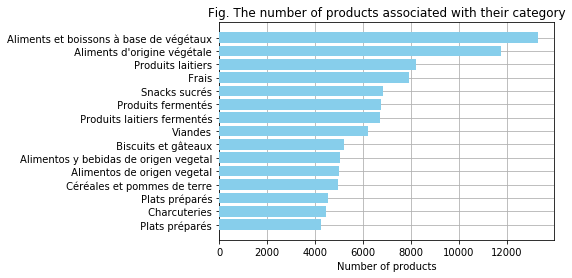

In [93]:
# Extract the 15 most frequent categories and number of occurances.
categories = target_categories.toPandas() 
categories = categories.head(15)

# Plot the most frequent categories
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.barh(categories.categories, categories.Count, zorder=3, color='skyblue')
plt.xlabel('Number of products')   
plt.title('Fig. The number of products associated with their category')
ax.invert_yaxis() 
plt.show()

In [95]:
categories.categories.head(20)

0     Aliments et boissons à base de végétaux
1                 Aliments d'origine végétale
2                           Produits laitiers
3                                       Frais
4                               Snacks sucrés
5                          Produits fermentés
6                 Produits laitiers fermentés
7                                     Viandes
8                         Biscuits et gâteaux
9       Alimentos y bebidas de origen vegetal
10                Alimentos de origen vegetal
11                Céréales et pommes de terre
12                             Plats préparés
13                               Charcuteries
14                             Plats préparés
Name: categories, dtype: object

In [158]:
# Extract the most important manufacturer countries for 15 most frequent categories

products_cats_df = eu_categories.toPandas()

countries_cats = []

for index, row in categories.iterrows():
    temp_df = pd.DataFrame(columns=['country','percentage'])
    filtered_df = products_cats_df[(products_cats_df.categories == row.categories)]
    total = len(filtered_df.code)
    filtered_df_g = filtered_df.groupby('manufacturing_places').count().sort_values(by=['code'], ascending=False).head(5)
    temp_df.country = filtered_df_g.index
    for index,row in temp_df.iterrows():
        temp_df.percentage.iloc[index] = filtered_df_g.code[index]/total
    
    countries_cats.append(temp_df)
# Each element of countries_cats is a dataframe containing the most important manufacturers
# of the corresponding category

In [162]:
for i in range(len(countries_cats)):
    print("category: " + str(categories.iloc[i].categories))
    print(countries_cats[i].country.values)
    print(countries_cats[i].percentage.values)
    print("\n")

category: Aliments et boissons à base de végétaux
['FR' 'IT' 'SP' 'GM' 'BE']
[0.6832769635475385 0.10462232243517475 0.04036076662908681
 0.03697857948139797 0.03314543404735062]


category:  Aliments d'origine végétale
['FR' 'IT' 'SP' 'GM' 'SZ']
[0.6656170212765957 0.1137872340425532 0.04553191489361702
 0.03846808510638298 0.032680851063829786]


category: Produits laitiers
['FR' 'IT' 'SZ' 'NL' 'GM']
[0.8416828793774319 0.04462548638132296 0.03818093385214008
 0.016536964980544747 0.014591439688715954]


category:  Frais
['FR' 'IT' 'SW' 'SP' 'UK']
[0.9293567547074435 0.022115506129154555 0.010236319979780108
 0.010109945659042083 0.008467079489447743]


category: Snacks sucrés
['FR' 'SZ' 'BE' 'UK' 'GM']
[0.6527960286173164 0.08994013724631333 0.0633669148780844
 0.05475251861585633 0.05416849175062053]


category:  Produits fermentés
['FR' 'IT' 'SZ' 'NL' 'GM']
[0.8380302580836547 0.04805695639276179 0.035597745476119845
 0.01913378819341442 0.01913378819341442]


category:  Produits 

We will use extracted information about the most important manufacturer countries for 15 most frequent categories for our visualization.